In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

In [2]:
users = pd.read_csv('data/montreal_users.csv')
users = users.drop('Unnamed: 0', axis=1)

montreal_reviews = pd.read_csv('data/montreal_reviews.csv')
montreal_reviews = montreal_reviews.drop('Unnamed: 0', axis=1)

business = pd.read_csv('data/business.csv')
business = business.drop('Unnamed: 0', axis=1)
montreal_business = business[business['city'] == 'Montréal']

### Questions to answer:

##### Q1
What is the distribution of friends and fans for those whole leave reviews? - Important to understand whether a simple average will capture enough information or whether more complex measures will be required.

Hypothesis: The distribution of friends and fans will be heavily right skewed and therefore the median value will be very low but there will be a few "influencer" reviewers who will perhaps have more of an impact and we wish to capture this information


In [3]:
# Pick a random business from the montreal dataset with a review count of at least 100

In [4]:
random_business_id = montreal_business[montreal_business['review_count'] > 100].sample(n=1, random_state=26)['business_id']
random_business_id_value = list(random_business_id.values)

In [5]:
random_business_id_value[0]

'XKPosZx2j4RHcZ8Ewdwj0A'

Get all the users who have left a review on that business

In [6]:
users_who_reviewed = montreal_reviews[montreal_reviews['business_id'] == random_business_id_value[0]]['user_id']

In [7]:
set_of_users = set(users_who_reviewed.values)

In [8]:
subset_of_users = users[users['user_id'].isin(set_of_users)]
subset_of_users = subset_of_users.reset_index(drop=True)

Count the number of friends for each user

In [9]:
subset_of_users['count_friends'] = [len(row[-7].split(',')) for row in subset_of_users.itertuples()]

Plot the distributions

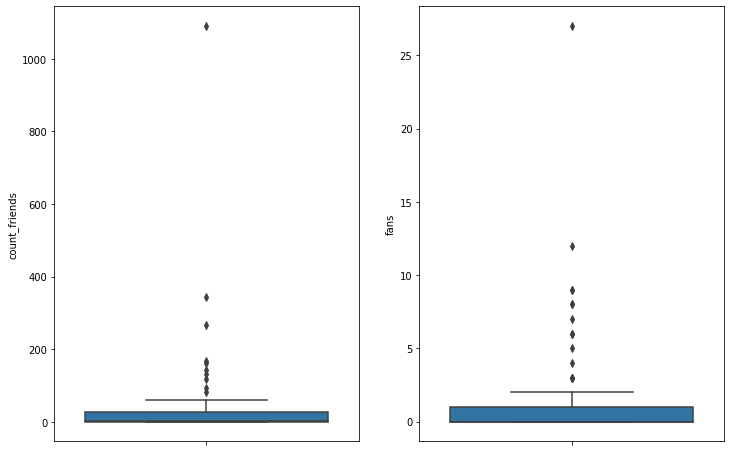

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,8))
sns.boxplot(subset_of_users['count_friends'], orient='v', ax=ax[0])
sns.boxplot(subset_of_users['fans'], orient='v', ax=ax[1])
plt.show()

In [11]:
print("Average number of friends {}".format(np.mean(subset_of_users['count_friends'])))
print("Average number of fans {}".format(np.mean(subset_of_users['fans'])))

Average number of friends 37.53191489361702
Average number of fans 1.5638297872340425


Now view the distribution as a whole across the full monteal users

In [12]:
users['count_friends'] = [len(row[-7].split(',')) for row in users.itertuples()]

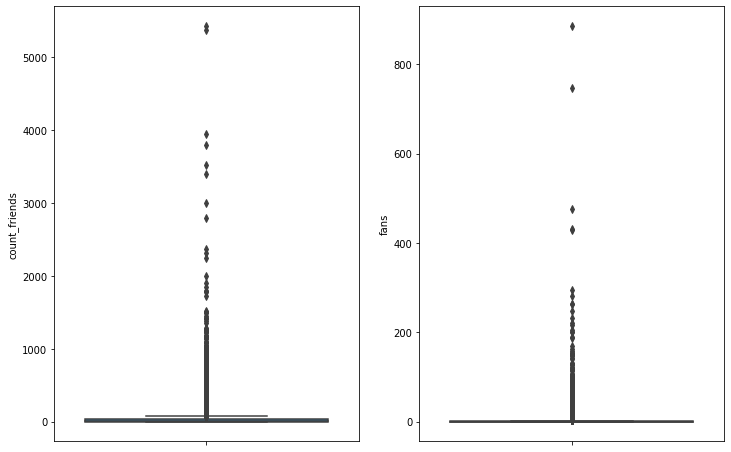

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,8))
sns.boxplot(users['count_friends'], orient='v', ax=ax[0])
sns.boxplot(users['fans'], orient='v', ax=ax[1])
plt.show()

In [14]:
print("Average number of friends {}".format(np.mean(users['count_friends'])))
print("Average number of fans {}".format(np.mean(users['fans'])))

Average number of friends 38.60733753304827
Average number of fans 1.6654372164376408


Given the full distributions it looks like the hypothesis was true, the vast majority of users have very few friends and fans and the mean number is very lower compared to some of the outliers (right skewed). Therefore taking just the mean value will lose of a lot of information about those reviewers who we suspect will have a big impact on restaurant popularity. To keep all this information take the mean value of friends for the restaurant, the number of "outlier" reviewers (taken from the full distribution of friends and fans) and also the total number of friends and fans reached by the reviews.

Take the IQR of the distribution of friends and fans to find the "outlier" threshold (using the standard 1.5*IQR heuristic)

In [15]:
# Friends
Q1, Q3 = np.percentile(users['count_friends'], [25 ,75])
IQR = Q3 - Q1
influencer_friend_threshold = Q3 + (IQR*1.5)

# Fans
Q1, Q3 = np.percentile(users['fans'], [25 ,75])
IQR = Q3 - Q1
influencer_fan_threshold = Q3 + (IQR*1.5)

### Data extraction

Wish to be able to view by business:

* Mean number of reviewer's friends
* Mean number of reviewer's fans
* Number of outlier reviewers (by friends)
* Number of outlier reviewers (by fans)
* Total number of revier's friends
* Total number of revier's fan

Also related to the activity of the users:
 
* Mean number of reviews per reviewer
* Mean number of reviers per reviewer per month


In [16]:
# Get the last review to represent the end of the dataset
latest_review = sorted(montreal_reviews['date'], reverse=True)[0]

In [17]:
# Convert dates
latest_review = datetime.datetime.strptime(latest_review, '%Y-%m-%d %H:%M:%S')
users['yelping_since_date'] = [datetime.datetime.strptime(x[-2], '%Y-%m-%d %H:%M:%S') for x in users.itertuples()]

# average days per month
av_day_per_month = 30.44

In [18]:
users['months_of_activity'] = latest_review - users['yelping_since_date']
users['months_of_activity'] = [x.days for x in users['months_of_activity']]
users['months_of_activity'] = round(users['months_of_activity']/av_day_per_month)

In [22]:
users['reviews_per_month'] = users['review_count'] / users['months_of_activity']

Join the business and user table together to summarise per business

In [52]:
def mystery(s1,s2):
    result=[]
    
    for ch in s1:
        if ch in s2:
            result.append(ch)
            
    return ''.join(result)

print(mystery('toot', 'top'))

toot


In [54]:
# Ensure all ids are string
montreal_reviews['user_id'] = montreal_reviews['user_id']
montreal_reviews['business_id'] = [str(x) for x in montreal_reviews['business_id']]
users['user_id'] = [str(x) for x in users['user_id']]
montreal_business['business_id'] = [str(x) for x in montreal_business['business_id']]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [55]:
montreal_reviews_join = montreal_reviews.copy() 

In [59]:
montreal_reviews_join.dtypes

business_id    object
cool            int64
date           object
funny           int64
review_id      object
stars           int64
text           object
useful          int64
user_id        object
dtype: object

In [56]:
montreal_reviews_join.join(users, how='left', on='user_id')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [40]:
business_to_join

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
82,8261 Saint-Laurent Boulevard,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...",i_oghUPqLzzJtxC6Zm-D2A,"Canadian (New), Portuguese, Restaurants",Montréal,"{'Monday': '11:30-21:0', 'Tuesday': '11:30-21:...",1,45.539733,-73.633639,Braseiro,H2P 2M1,22,4.0,QC
84,2425 Boulevard Gouin E,"{'GoodForKids': 'True', 'BikeParking': 'True',...",735UkyT4px_oeW3iyotGmA,"Parks, Active Life",Montréal,"{'Monday': '9:0-16:30', 'Tuesday': '9:0-16:30'...",1,45.583898,-73.653778,Parc-nature de l'Île-de-la-Visitation,H2B 1X7,10,4.5,QC
92,10897 Rue du Pont,"{'OutdoorSeating': 'True', 'WiFi': ""u'free'"", ...",SWX0K1dpy4fcRq-ktZxmCg,"Landmarks & Historical Buildings, Mediterranea...",Montréal,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.574857,-73.661130,Bistro des Moulins,H2B 2H3,3,3.5,QC
180,134 Rue Jean-Talon O,"{'OutdoorSeating': 'False', 'RestaurantsPriceR...",spi9UEWyNrq2O4y5DD84LA,"Vietnamese, Restaurants, Soup",Montréal,"{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",0,45.533111,-73.619518,Restaurant Nhu Y,H2R 2X1,11,4.0,QC
194,5411 rue Beaubien E,{'ByAppointmentOnly': 'True'},cBQDYO0dIpG6--I3DMiWoQ,"Hair Removal, Beauty & Spas, Shopping, Laser H...",Montréal,"{'Tuesday': '10:0-18:0', 'Wednesday': '10:0-18...",1,45.575935,-73.568558,Secrets de Femme,H1T 1W7,3,1.0,QC
236,6950 Rue Saint-Denis,"{'RestaurantsPriceRange2': '2', 'RestaurantsRe...",NqpX1HsFVGwmnxnw_bcEuA,"Restaurants, American (Traditional)",Montréal,NaN,0,45.537091,-73.612181,Aux Derniers Humains,H2S 2S4,8,4.0,QC
248,7622 Rue Saint-Hubert,"{'Alcohol': ""u'full_bar'"", 'BusinessParking': ...",3E0JDI0XMUoFztoEmX2D7w,"Nightlife, Bars",Montréal,"{'Monday': '16:0-3:0', 'Tuesday': '16:0-3:0', ...",1,45.543774,-73.620155,Le Record,H2R 2N6,3,3.5,QC
258,3435 Boulevard St-Laurent,NaN,4Rp1y8L_zecjHt6AvKtekg,"Cajun/Creole, Restaurants",Montréal,NaN,1,45.512884,-73.569970,Factory,H2X 1C2,3,2.5,QC
309,"417 Rue Saint-Pierre, Suite 101","{'OutdoorSeating': 'False', 'RestaurantsGoodFo...",LF66oShCh30k5NOV6pPJTQ,"Coffee & Tea, Cafes, Restaurants, Bakeries, Ju...",Montréal,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",1,45.501661,-73.556605,Flyjin Café,H2Y,17,4.5,QC
311,2 Rue Sherbrooke E,"{'RestaurantsGoodForGroups': 'True', 'Restaura...",9uhXxFrTR58KVD5fq1ua3Q,"Restaurants, Burgers, Poutineries, Canadian (New)",Montréal,NaN,0,45.512533,-73.569296,Jerry Ferrer,H2X 1C2,10,4.0,QC


,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,wg-1uNV3xHrjWEmULlAFPg,0,2016-11-02 21:01:25,0,QkDH2rXm7ZViM6e_02H9ZA,5,"Mon amie et moi sommes arrivées vers 13h, il y...",2,FdMNvBDX--D_MWuu5qKWDw
1,JuhbUwZRKoDsc1zACJGxxQ,0,2014-07-06 13:24:52,0,X-g4dKDjiBQpaHwW5VLKeA,4,Difficult to find in NYC but easily available ...,1,R1bIQRSNg0us37blGV5JrQ
2,FuYcbqKT2JKD05RYvvELaw,0,2017-10-08 01:24:49,0,Yl8oC4pYReC99KCm4Bsvkw,4,Fun place. Good drinks and a casual crowd...\...,0,eyf2Vv31Njmn68GVW4JrsQ
3,46Ld9Qc9nAx_A0jwclNZiw,0,2017-09-28 00:44:06,0,dipNbrgs-jkWgvFAOg_wlw,4,"I really love that place, perfect for a nice l...",0,rJqmB3F93EwLxUSKFLGg1w
4,cemMv5hvZZPj-_1V4xT9rQ,0,2017-10-18 00:32:30,0,9ucf0ZZpqhtH18Hqhsq0hw,5,Absolutely top notch. We truly enjoyed our foo...,0,zhT5MLTV4lyekxSQbqbT-w
5,CqKa_LEbFfhwCVCmcn1Q4g,0,2015-10-03 14:41:43,0,C2E90AOKN01hw53l_JKPVw,4,We loved this little restaurant. Service was o...,0,bxaICaGxzYHSB1MsztlGdg
6,k2a0B5nlT3V9zzVrpgcGeQ,3,2017-08-03 15:43:56,1,82FA8BfF5Zfob-xno1SqSw,5,My only NICE sit-down dinner while visiting Mo...,1,HkgxlKEdsdEK-qsiBgrq6Q
7,lLYN1L0JdnseIYa6UUVA5A,0,2017-02-14 15:12:12,1,2zO35ia4nSbdXgdh4CAmLA,5,Toujours aussi cool le service et souriant vra...,0,KGPPQsnPBJpUxCXBVuSpEw
8,zhc2S7yhYfbKTM-c08E1bA,0,2014-08-02 20:03:40,0,cn9HjZnLvjNW1oVvVNFmgw,1,Only gave them one star because you can't give...,1,eYjq231DkLwmaF_4x8zang
9,5XX1w4WbwSlrACQ5vKuLDw,0,2018-06-25 03:06:24,0,f0L1Gzcxet6LadXffXPZ3Q,2,Walked into the place very hungry so everythin...,0,UV4iIu0CqfIgLlpNLvt5ZA
